In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#### Константы модели

In [2]:
m1 = 4.15       # кг, масса платформы
mk = 1.1        # кг, масса ведущего колеса
J1 = 0.7        # кг·м², момент инерции робота
Jy = 0.00028    # кг·м², момент инерции колеса
a = 0.15        # м, расстояние от центра масс до точки крепления
a1 = 0.1        # м, расстояние от платформы до центра масс
r = 0.075       # м, радиус ведущего колеса
l = 0.2         # м, половина расстояния между ведущими колёсами
h = 0.15        # м, высота центра масс
n = 5           # передаточное число
c = 0.01        # В·с, коэффициент электромеханической связи
R = 1.0         # Ом, сопротивление цепи ротора
L = 0.0002      # Гн, индуктивность цепи
delta = 0.00075 # коэффициент трения качения
g = 9.81        # м/с², ускорение свободного падения
f = 0.1         # коэффициент трения скольжения
U0 = 3.2        # В, базовое управляющее напряжение
k = 0.1         # коэффициент управления

#### Траектория

In [3]:
L_traj = 15
x0 = 5
traj_k = 1.5

In [4]:
def logistic_trajectory(x):
    return L_traj / (1 + np.exp(-traj_k * (x - x0)))

def logistic_derivative(x):
    return (L_traj * traj_k * np.exp(-traj_k * (x - x0))) / (1 + np.exp(-traj_k * (x - x0)))**2

In [5]:
x_points = np.linspace(0, 10, 1000)
y_points = logistic_trajectory(x_points)

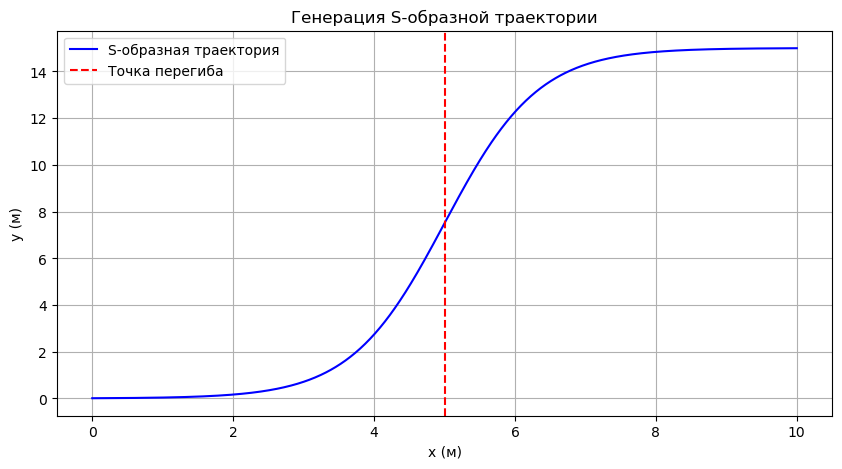

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(x_points, y_points, label="S-образная траектория", color='blue')
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.title("Генерация S-образной траектории")
plt.axvline(x=x0, color="red", linestyle="--", label="Точка перегиба")
plt.grid()
plt.legend()
plt.show()

#### Вычисление общей массы и момента инерции

In [7]:
m = m1 + 2 * mk + 2 * Jy / r**2
J = J1 + (m1 + 2 * mk) * a**2 + 2 * Jy / r**2 * l**2

#### Расчет уравнения движения

In [8]:
def calculate_curvature_radius(a, beta):
    return abs(a / np.sin(beta)) if np.sin(beta) != 0 else np.inf

def calculate_beta(V, Omega, a):
    return np.pi / 2 if V == 0 else np.arctan(Omega * a / V)

def calculate_normal_force_limit(m1, mk, g, a, a1):
    return (m1 + 2 * mk) * g * a1 / (2 * (a + a1))

In [9]:
def calculate_normal_forces(V, Omega, Omega_dot, m1, mk, g, a, a1, r, l, beta, rho):
    common_factor = (m1 + 2 * mk) / 2
    term1 = g * a1 / (a + a1)
    term2 = r * (V**2 + (Omega * a)**2) * np.cos(beta) * np.sign(Omega) / (l * rho)
    term3 = Omega_dot * a / rho
    N1 = common_factor * (term1 + term2 + term3)
    N2 = common_factor * (term1 - term2 - term3)
    return N1, N2

In [10]:
def calculate_friction_moments(phi_dot, i, N, delta, n, c):
    if phi_dot != 0:
        return -delta * N * np.sign(phi_dot)
    elif abs(n * c * i) <= delta * N:
        return -n * c * i
    else:
        return -delta * N * np.sign(i)

In [11]:
def check_wheel_detachment(V, Omega, Omega_dot, m1, mk, h, l, a, N_s):
    if V != 0:
        beta = np.arctan(Omega * a / V)
        cos_beta = np.cos(beta)
        sin_beta = np.sin(beta)
    else:
        cos_beta = 0
        sin_beta = 1
    left_term = (m1 + 2 * mk) * h / (2 * l) * (V**2 + (Omega * a)**2) * cos_beta * sin_beta
    return left_term > N_s

In [12]:
def equations_of_motion(t, y):
    x, y_pos, psi, phi1, phi2, i1, i2, V, Omega = y
    y_target = logistic_trajectory(x)
    Delta = y_target - y_pos

    U1 = U0 + k * Delta
    U2 = U0 - k * Delta

    Omega_dot = 0
    beta = calculate_beta(V, Omega, a)
    rho = calculate_curvature_radius(a, beta)
    N1, N2 = calculate_normal_forces(V, Omega, Omega_dot, m1, mk, g, a, a1, r, l, beta, rho)
    Mfr1 = calculate_friction_moments(phi1, i1, N1, delta, n, c)
    Mfr2 = calculate_friction_moments(phi2, i2, N2, delta, n, c)
    N_s = calculate_normal_force_limit(m1, mk, g, a, a1)
    if check_wheel_detachment(V, Omega, Omega_dot, m1, mk, h, l, a, N_s):
        print(f"Warning: Wheel detachment at time {t:.2f}s")

    dVdt = (n * c / r * (i1 + i2) + (Mfr1 + Mfr2) / r + m1 * a * Omega**2) / m
    dOmegadt = (n * c * l / r * (i1 - i2) + l / r * (Mfr1 - Mfr2) - m1 * a * V * Omega) / J
    di1dt = (U1 - R * i1 - n * c / r * (V + l * Omega)) / L
    di2dt = (U2 - R * i2 - n * c / r * (V - l * Omega)) / L
    dxdt = V * np.cos(psi)
    dydt = V * np.sin(psi)
    dpsidt = Omega
    dphi1dt = V / r + Omega * l / r
    dphi2dt = V / r - Omega * l / r

    return [dxdt, dydt, dpsidt, dphi1dt, dphi2dt, di1dt, di2dt, dVdt, dOmegadt]

In [13]:
# Решение системы
initial_conditions = [0.3, 0.0, np.arctan(logistic_derivative(0.3)), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
time_span = (0, 20)
solution = solve_ivp(equations_of_motion, time_span, initial_conditions, t_eval=np.linspace(0, 20, 1000))

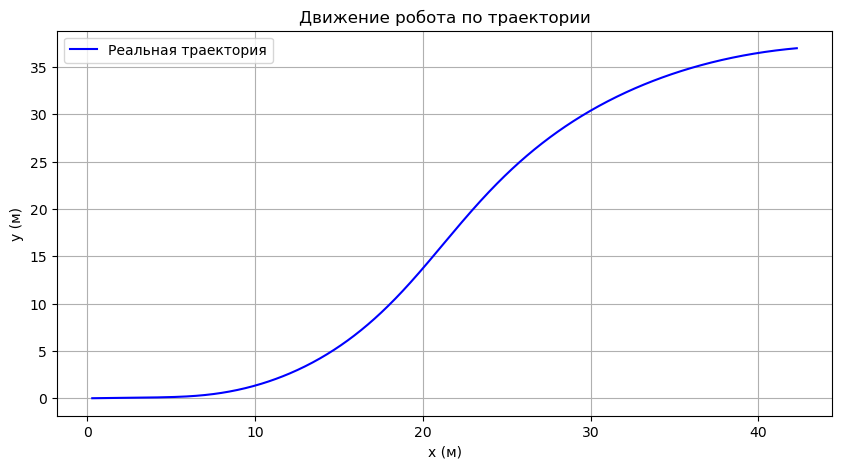

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(solution.y[0], solution.y[1], label="Реальная траектория", color='blue')
plt.xlabel("x (м)")
plt.ylabel("y (м)")
plt.title("Движение робота по траектории")
plt.legend()
plt.grid()
plt.show()

In [15]:
normal_forces = []

for i in np.linspace(0, len(solution.t) - 1, 10, dtype=int):
    N1i = calculate_normal_forces(solution.y[7][i], solution.y[8][i], 0, m1, mk, g, a, a1, r, l, calculate_beta(solution.y[7][i], solution.y[8][i], a), calculate_curvature_radius(a, calculate_beta(solution.y[7][i], solution.y[8][i], a)))[0]
    N2i = calculate_normal_forces(solution.y[7][i], solution.y[8][i], 0, m1, mk, g, a, a1, r, l, calculate_beta(solution.y[7][i], solution.y[8][i], a), calculate_curvature_radius(a, calculate_beta(solution.y[7][i], solution.y[8][i], a)))[1]
    normal_forces.append((N1i, N2i))

print("  N1     N2")
for (value1, value2) in normal_forces:
    print(f"{value1:.3f} {value2:.3f}")

  N1     N2
12.459 12.459
12.460 12.457
12.689 12.228
13.169 11.749
12.973 11.944
12.653 12.264
12.282 12.636
11.902 13.015
11.571 13.346
11.373 13.545
